### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [ ]:
# Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=afc267a7c1b6fb9c4fed507689b8e87a30a4d72a7100e35566f19ec9d606d0ae
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=907a26cdacca0b8fddaf494e494f5a40cf9ff3557e50f250f342b6e8fba8e46d
  Stored in directory: /root/.cache/pip/wheels/6a/aa

In [ ]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath as op

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Retrieve CollecTRI gene regulatory network
try:
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    collectri.to_csv("datasets/collectri.csv",index=False)
except:
    collectri = pd.read_table("datasets/collectri.csv", sep=',')
collectri

,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


In [ ]:
# Retrieve DoRothEA gene regulatory network
try:
    dorothea = dc.get_dorothea(organism='human')
    dorothea.to_csv("datasets/dorothea.csv",index=False)
except:
    dorothea = pd.read_table("datasets/dorothea.csv", sep=',')
dorothea

0.00B [00:00, ?B/s]

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [ ]:
# Download the data from GEO
try:
    !wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
    !gzip -d -f counts.txt.gz
    !mkdir datasets
    !mv counts.txt datasets/counts.txt
except:
    print("Error! Please upload counts.txt file manually.")

# Read raw data and process it
adata_table = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata_table

--2023-09-01 06:39:09--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  3.30MB/s    in 0.5s    

2023-09-01 06:39:10 (3.30 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]

mkdir: cannot create directory ‘datasets’: File exists


GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In [ ]:
# Transform to AnnData object
adata = AnnData(adata_table, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    layers: 'counts', 'cpm'

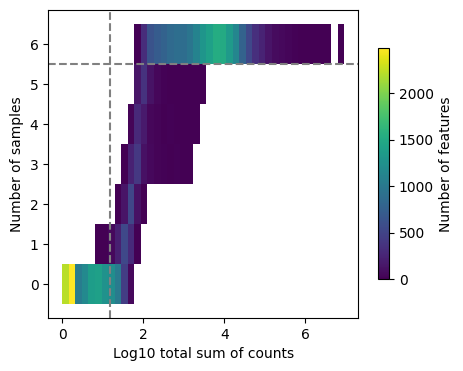

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X

# Visualize adata
adata_filtered

In [ ]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0.861613,0.600518,2.637059,1.305475,1.853774,0.496080,20.391516,51.644581,12.323682,628.011658,...,2433.196045,8.929447,12.428120,12.871981,1422.079712,448.665558,33.994560,1412.497559,6.736249,12.402010
26_HSCs-Ctrl2,1.341323,0.914539,2.581031,0.751954,0.975508,0.934862,18.026571,48.328281,9.734755,522.831543,...,2335.406250,7.214693,7.885355,8.860863,1314.862549,428.938904,30.322033,1273.830200,5.141739,8.047939
27_HSCs-Ctrl3,0.969110,0.633649,2.012767,0.838653,1.062294,0.465918,20.779961,56.823406,10.138384,572.576416,...,2895.496338,7.026049,8.162890,8.945633,1596.236328,593.766357,37.888481,1669.087402,5.255559,8.349257
31_HSCs-TGFb1,0.965408,0.536338,2.592299,0.500582,1.841426,0.536338,15.375017,44.802082,7.937799,367.212616,...,1982.054199,6.668467,7.884166,8.599282,1078.485962,348.548065,25.869360,1185.002563,3.075003,6.096373
32_HSCs-TGFb2,1.027534,0.653885,1.821537,0.607179,1.447888,0.607179,9.457981,26.295525,7.146030,227.505325,...,1062.283081,5.581377,7.729856,8.010093,640.854126,211.438431,14.572297,643.026001,2.241892,5.044257
33_HSCs-TGFb3,0.796692,0.522829,2.190902,0.423242,1.468900,0.248966,15.037556,47.253777,7.070639,369.415955,...,1760.290283,8.564435,11.278167,12.373617,1131.376831,343.473694,26.813654,1080.886475,4.780150,6.049877


In [ ]:
mat.apply([np.sum, np.min, np.max], axis=1)

,sum,amin,amax
25_HSCs-Ctrl1,1.000000e+06,0.234985,16724.437500
26_HSCs-Ctrl2,1.000000e+06,0.223554,20666.802734
27_HSCs-Ctrl3,1.000000e+06,0.223641,21531.746094
31_HSCs-TGFb1,1.000000e+06,0.232413,53465.296875
32_HSCs-TGFb2,1.000000e+06,0.233530,55140.593750
33_HSCs-TGFb3,1.000000e+06,0.224070,59497.929688


### **TASK 1** Without DEA

In [ ]:
# Infer TF activities with ulm using CollecTRI network
tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_collectri_acts

Running ulm on mat with 6 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
25_HSCs-Ctrl1,1.065369,3.513768,-0.092619,9.416823,3.750810,7.374182,2.209627,0.792456,-0.073562,-0.119644,...,2.369821,1.127670,-0.358643,17.152018,-0.152018,0.223835,0.792804,-0.641132,-0.200024,1.450069
26_HSCs-Ctrl2,1.030500,3.439764,-0.108949,9.543247,3.511437,7.277483,2.080467,0.805713,-0.070083,-0.108495,...,2.047254,1.055401,-0.310071,19.226736,-0.127963,0.200891,0.684690,-0.659765,-0.191540,1.307216
27_HSCs-Ctrl3,1.062467,3.423932,-0.105873,9.529863,3.719286,7.011393,2.019213,0.803646,-0.044515,-0.098158,...,2.195279,1.095722,-0.281857,19.752375,-0.130376,0.231477,0.739110,-0.655897,-0.193930,1.433861
31_HSCs-TGFb1,0.341344,2.637449,-0.137243,9.362064,1.862120,8.492096,0.501636,0.297469,-0.033156,-0.101031,...,0.258564,0.462094,-0.082978,16.974936,-0.076635,0.083366,0.223191,-0.273286,-0.090176,0.539266
32_HSCs-TGFb2,0.341261,2.539009,-0.125790,9.223310,1.679006,8.553974,0.518021,0.306204,-0.041595,-0.098013,...,0.221584,0.438338,-0.116582,16.314453,-0.093113,0.047600,0.247142,-0.285474,-0.080971,0.547607
33_HSCs-TGFb3,0.310873,2.437673,-0.130148,9.481165,1.448070,8.715354,0.467010,0.262756,-0.043612,-0.103782,...,0.259061,0.411983,-0.123147,14.641565,-0.087410,0.042556,0.246827,-0.249543,-0.083871,0.495250


In [ ]:
tf_collectri_acts.apply([np.sum, np.min, np.max], axis=1)

,sum,amin,amax
25_HSCs-Ctrl1,1512.819702,-24.703819,42.922180
26_HSCs-Ctrl2,1534.293457,-26.933605,47.015804
27_HSCs-Ctrl3,1508.543213,-27.172037,47.552635
31_HSCs-TGFb1,1526.789062,-26.792070,46.647263
32_HSCs-TGFb2,1520.657593,-27.133623,47.368748
33_HSCs-TGFb3,1517.293823,-28.461018,49.987930


In [ ]:
# Infer TF activities with ulm using DoRothEA network
tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
tf_dorothea_acts

Running ulm on mat with 6 samples and 17575 targets for 281 sources.


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
25_HSCs-Ctrl1,1.021086,3.672184,0.669489,0.081744,2.697176,0.406037,1.640476,9.651978,0.612117,1.249952,...,1.153679,-0.362536,2.313812,-0.243042,1.458922,0.229469,0.236344,0.888968,-0.119325,0.818214
26_HSCs-Ctrl2,0.837120,3.125765,0.522897,0.059671,2.484155,0.425281,1.518833,11.370803,0.600986,1.228788,...,1.089787,-0.348231,2.313849,-0.225304,1.381332,0.223435,0.209429,0.743977,-0.103536,0.821655
27_HSCs-Ctrl3,0.733425,3.235074,0.362701,0.039755,2.302288,0.379323,1.453785,9.988415,0.632513,1.174859,...,0.941741,-0.352394,2.391270,-0.243336,1.257836,0.177968,0.197425,0.655634,-0.124677,0.821915
31_HSCs-TGFb1,0.146720,1.907997,0.176476,0.030676,1.489435,0.167627,0.882310,24.084148,0.323295,0.646517,...,0.294664,-0.155068,0.951346,-0.236343,0.557975,0.017112,0.024222,0.267927,-0.058889,0.247535
32_HSCs-TGFb2,0.142365,1.933520,0.198579,0.066514,1.523887,0.155074,0.908797,24.430395,0.302602,0.680592,...,0.323096,-0.145248,0.818233,-0.234875,0.546379,0.014626,0.004064,0.317364,-0.036936,0.213982
33_HSCs-TGFb3,0.148002,1.912735,0.190550,0.049040,1.451231,0.150502,0.834315,25.430475,0.284248,0.620383,...,0.334270,-0.142322,0.814429,-0.233602,0.530376,0.006014,-0.006023,0.318174,-0.029797,0.211474


In [ ]:
tf_dorothea_acts.apply([np.sum, np.min, np.max], axis=1)

,sum,amin,amax
25_HSCs-Ctrl1,635.993042,-12.582962,21.321955
26_HSCs-Ctrl2,622.982788,-12.979745,22.768751
27_HSCs-Ctrl3,611.415894,-12.806852,23.071545
31_HSCs-TGFb1,426.819550,-16.017735,35.416481
32_HSCs-TGFb2,417.465210,-16.220863,35.726379
33_HSCs-TGFb3,408.917358,-15.880569,37.195339


In [ ]:
# Find common columns
matched_columns = tf_collectri_acts.columns.intersection(tf_dorothea_acts.columns)

# Merge two dataframes based on the matched columns
df_merged = pd.merge(tf_collectri_acts[matched_columns], tf_dorothea_acts[matched_columns], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_mean = pd.concat([df_merged.iloc[0:3,].mean(),df_merged.iloc[3:6,].mean()], axis = 1).T.rename(index={0:"control",1:"treatment"})
df_merged_mean

,AHR_collectri,AR_collectri,ARID3A_collectri,ARNT_collectri,ASCL1_collectri,ATF1_collectri,ATF2_collectri,ATF3_collectri,ATF4_collectri,ATF6_collectri,...,YY1_dorothea,ZBED1_dorothea,ZBTB33_dorothea,ZBTB7A_dorothea,ZEB1_dorothea,ZEB2_dorothea,ZHX2_dorothea,ZNF143_dorothea,ZNF263_dorothea,ZNF384_dorothea
control,3.459154,7.221019,0.800605,1.148278,2.625024,2.585873,6.307606,5.816425,3.477003,2.447046,...,0.161761,0.747967,1.157385,3.352445,7.367555,5.220081,1.031183,1.004166,2.339644,1.36603
treatment,2.538044,8.587142,0.288810,1.419675,1.741647,-0.170205,12.820328,13.503880,1.346324,1.339911,...,0.384181,0.162143,0.404810,1.196622,5.209786,2.260386,0.283522,0.361718,0.861336,0.54491


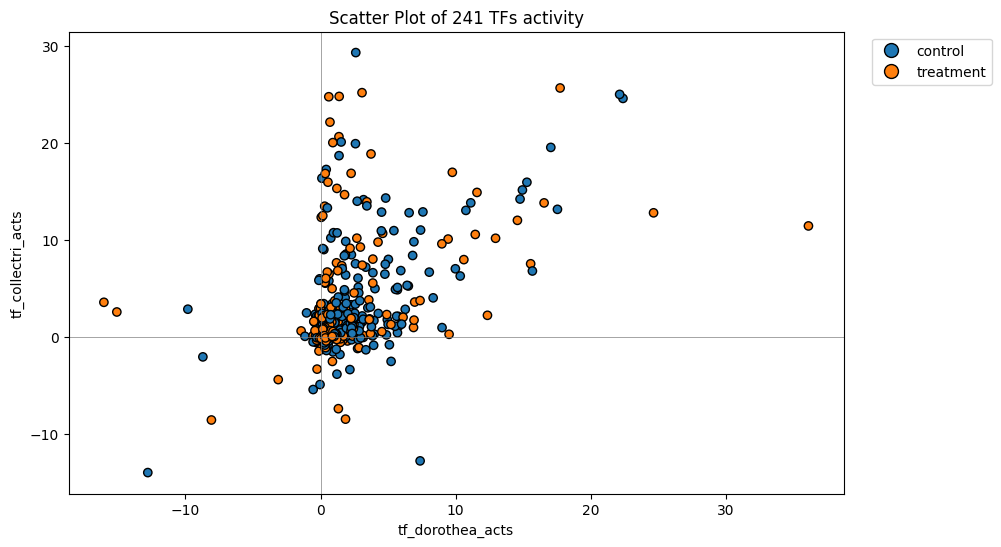

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

color2 = sns.color_palette(None, 2)

for col in matched_columns:
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean,
                    hue=[0,1],
                    palette=color2,
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)

# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=color2[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns)} TFs activity')
plt.show()

In [ ]:
# Filter p-value < 0.05 in collectri TF activity
tf_collectri_acts_filtered = tf_collectri_acts.loc[:, tf_collectri_pvals.lt(0.05).all()]
tf_collectri_acts_filtered

,AHR,AP1,AR,ATF2,ATF3,BARX1,BARX2,BMAL1,BMAL2,CEBPA,...,VHL,YBX1,YY1,ZBTB14,ZBTB16,ZBTB4,ZFP42,ZGLP1,ZNF148,ZNF384
25_HSCs-Ctrl1,3.513768,9.416823,7.374182,6.056330,5.635913,4.049629,2.883213,2.306775,2.228354,8.215017,...,4.312321,-8.816461,8.715239,-7.686011,10.144409,5.148832,3.300120,6.542153,9.345636,17.152018
26_HSCs-Ctrl2,3.439764,9.543247,7.277483,6.752047,6.186154,3.851630,2.808856,2.324536,2.347502,8.492769,...,4.857441,-10.091207,9.215903,-7.257282,11.481839,4.486597,3.533165,6.148282,9.595936,19.226736
27_HSCs-Ctrl3,3.423932,9.529863,7.011393,6.114440,5.627210,3.640292,2.906451,2.468801,2.606156,8.557335,...,4.985879,-10.294966,9.471114,-7.769149,11.818234,4.230925,3.454285,6.492667,9.254605,19.752375
31_HSCs-TGFb1,2.637449,9.362064,8.492096,12.579825,13.259231,3.080267,3.460933,2.183405,4.050226,10.044015,...,5.213822,-8.340517,6.307020,-4.354980,10.405132,3.319607,3.641953,3.478489,5.559693,16.974936
32_HSCs-TGFb2,2.539009,9.223310,8.553974,12.704719,13.202457,3.196628,3.380829,1.966735,3.579390,9.849190,...,5.357178,-8.189095,6.155406,-3.883572,9.969989,3.625682,3.990290,3.143332,5.829835,16.314453
33_HSCs-TGFb3,2.437673,9.481165,8.715354,13.176441,14.049950,3.005480,3.363166,2.047482,3.931874,10.455815,...,5.161090,-7.562925,5.731775,-3.406056,8.942389,3.580748,3.684166,2.759246,5.565330,14.641565


In [ ]:
# Filter p-value < 0.05 in dorothea TF activity
tf_dorothea_acts_filtered = tf_dorothea_acts.loc[:, tf_dorothea_pvals.lt(0.05).all()]
tf_dorothea_acts_filtered

,ATF2,ATF6,CEBPA,CEBPD,CREB1,EGR1,ELK1,EPAS1,ERG,ESR1,...,TEAD4,TFAP2A,TFAP2C,TP53,TWIST1,USF1,USF2,WT1,ZEB1,ZEB2
25_HSCs-Ctrl1,9.651978,4.558881,6.939257,7.597912,5.262105,11.256096,4.977552,6.495694,4.931658,6.023301,...,5.280015,11.111717,3.822433,8.157110,4.925829,4.796582,5.820758,3.771947,7.565924,5.333564
26_HSCs-Ctrl2,11.370803,4.129539,7.006742,7.418501,6.364274,11.196413,4.793649,6.341383,4.869390,5.992967,...,4.917507,10.254299,3.827844,8.038004,4.362162,4.732239,5.762555,3.809760,7.463633,5.112087
27_HSCs-Ctrl3,9.988415,4.124165,6.498979,7.707770,5.442345,10.899292,4.850954,6.652720,5.013714,5.794549,...,4.807171,10.903830,3.641168,7.941586,4.261085,4.842383,5.489714,3.472260,7.073108,5.214593
31_HSCs-TGFb1,24.084148,2.472003,9.288297,4.510812,15.151475,11.619241,3.890440,7.213969,2.396477,3.549468,...,4.646106,4.019162,2.318670,7.092839,3.815943,4.029725,5.040974,3.677671,5.270473,2.422393
32_HSCs-TGFb2,24.430395,2.430310,9.436659,4.153845,15.371550,11.487496,3.723215,6.922911,2.109338,3.589602,...,4.631643,3.740860,2.232941,7.044346,3.851121,3.700996,4.968072,3.762090,5.183165,2.139276
33_HSCs-TGFb3,25.430475,2.287618,9.597309,4.091480,16.128105,11.626188,3.464934,6.763782,2.142684,3.571707,...,4.330340,3.848060,2.204659,6.615674,3.530662,3.859724,4.681488,3.366129,5.175720,2.219488


In [ ]:
# Find common columns
matched_columns_filtered = tf_collectri_acts_filtered.columns.intersection(tf_dorothea_acts_filtered.columns)

# Merge two dataframes based on the matched columns
df_merged_filtered = pd.merge(tf_collectri_acts_filtered[matched_columns_filtered], tf_dorothea_acts_filtered[matched_columns_filtered], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_filtered_mean = pd.concat([df_merged_filtered.iloc[0:3,].mean(),df_merged_filtered.iloc[3:6,].mean()], axis = 1).T.rename(index={0:"control",1:"treatment"})
df_merged_filtered_mean

,ATF2_collectri,CEBPA_collectri,CEBPD_collectri,CREB1_collectri,EGR1_collectri,EPAS1_collectri,ESR1_collectri,ETS1_collectri,ETV4_collectri,FOS_collectri,...,SP1_dorothea,SP3_dorothea,SPI1_dorothea,SRF_dorothea,STAT1_dorothea,TBP_dorothea,TFAP2A_dorothea,TWIST1_dorothea,USF1_dorothea,USF2_dorothea
control,6.307606,8.421707,12.912441,4.889843,13.848778,5.280023,6.865137,15.174264,4.055309,6.502291,...,7.403031,14.765106,3.871781,15.272679,9.976930,15.678473,10.756615,4.516359,4.790402,5.691009
treatment,12.820328,10.116340,9.801749,7.568696,14.923134,3.623824,3.849170,16.996002,2.257694,10.207952,...,8.978395,12.951866,2.182137,11.449157,7.363917,36.112732,3.869361,3.732575,3.863482,4.896845


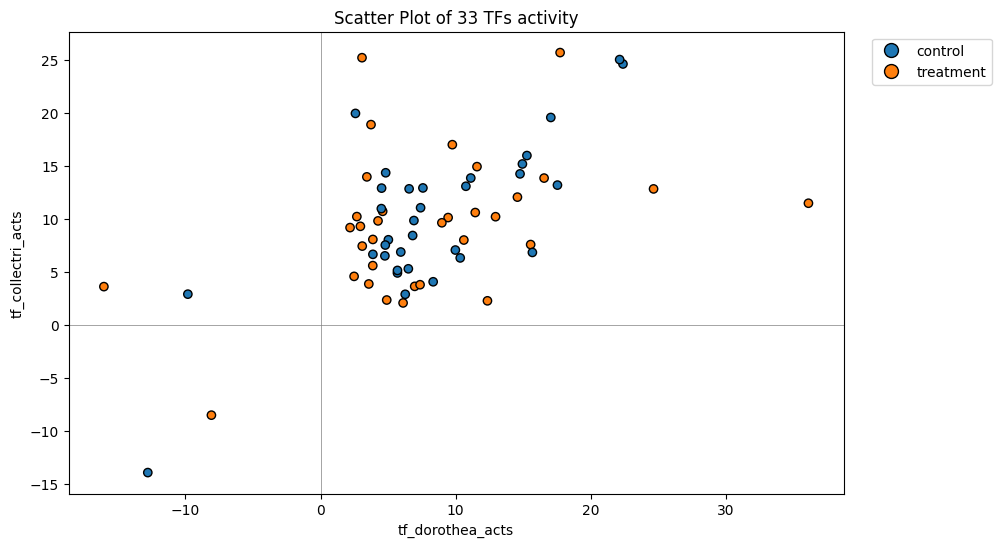

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

color2 = sns.color_palette(None, 2)

for col in matched_columns_filtered:
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean,
                    hue=[0,1],
                    palette=color2,
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)

# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=color2[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_filtered_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered)} TFs activity')
plt.show()

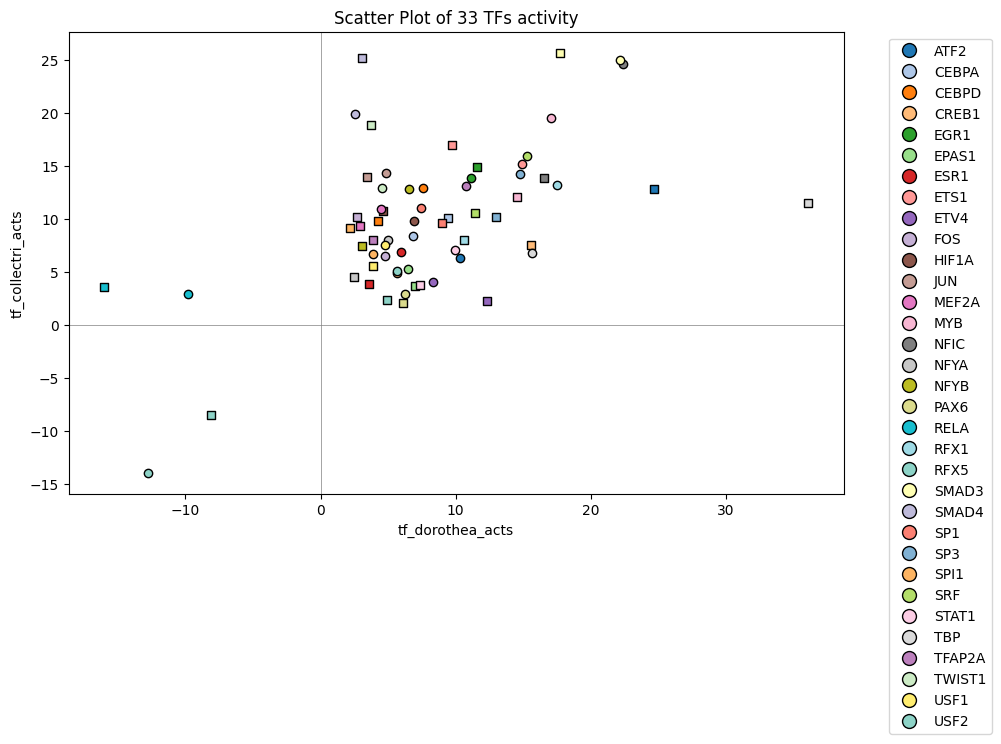

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

for i, col in enumerate(matched_columns_filtered):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[0]],
                    color=colors[i],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[1]],
                    color=colors[i],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)


# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(matched_columns_filtered)]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered)} TFs activity')
plt.show()

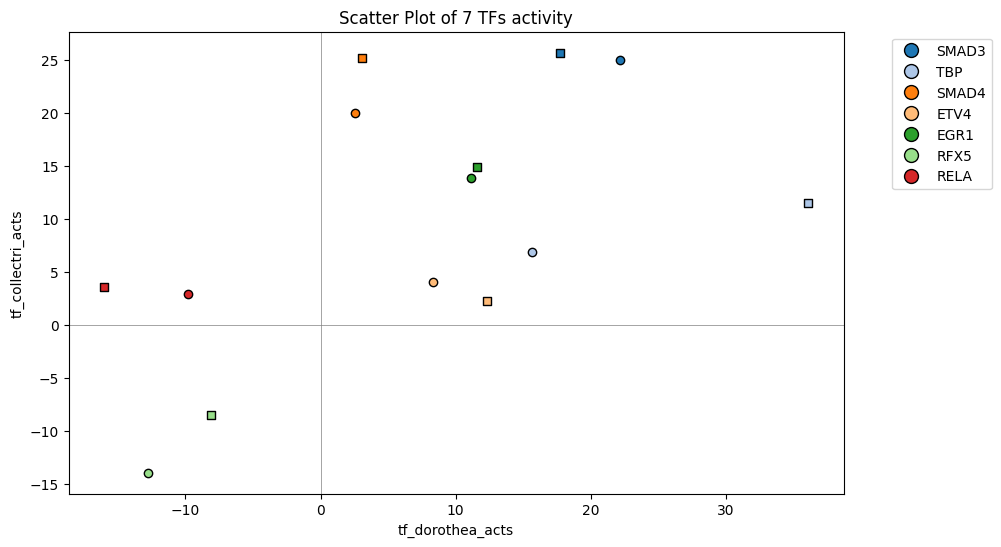

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

matched_columns_filtered_selected = ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

for i, col in enumerate(matched_columns_filtered_selected):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[0]],
                    color=colors[i],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[1]],
                    color=colors[i],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)


# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(matched_columns_filtered_selected)]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered_selected)} TFs activity')
plt.show()

In [ ]:
# Get raw TFs activity score of the selected TFs
matched_columns_filtered_selected = ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

# Filter columns
collectri_columns = [f"{col}_collectri" for col in matched_columns_filtered_selected] # matched_columns_filtered_selected
dorothea_columns = [f"{col}_dorothea" for col in matched_columns_filtered_selected] # matched_columns_filtered_selected

collectri_df = df_merged_filtered_mean[collectri_columns].T
collectri_df.index = matched_columns_filtered_selected

dorothea_df = df_merged_filtered_mean[dorothea_columns].T
dorothea_df.index = matched_columns_filtered_selected

# Re-arrange the column index to multi-level index
collectri_df.columns = pd.MultiIndex.from_product([['collectri'], collectri_df.columns], names=["Source", "Condition"])
dorothea_df.columns = pd.MultiIndex.from_product([['dorothea'], dorothea_df.columns], names=["Source", "Condition"])

# Add "difference" column
collectri_df[('collectri', 'difference')] = collectri_df[('collectri', 'treatment')] - collectri_df[('collectri', 'control')]
dorothea_df[('dorothea', 'difference')] = dorothea_df[('dorothea', 'treatment')] - dorothea_df[('dorothea', 'control')]

df_merged_filtered_selected = pd.concat([collectri_df, dorothea_df], axis=1)
df_merged_filtered_selected

Source     collectri                         dorothea                      
Condition    control  treatment difference    control  treatment difference
SMAD3      25.028122  25.687714   0.659592  22.138002  17.730715  -4.407288
TBP         6.824885  11.469475   4.644590  15.678473  36.112732  20.434258
SMAD4      19.946287  25.204620   5.258333   2.581891   3.066614   0.484724
ETV4        4.055309   2.257694  -1.797615   8.333816  12.352183   4.018368
EGR1       13.848778  14.923134   1.074356  11.117267  11.577641   0.460375
RFX5      -13.953298  -8.533314   5.419984 -12.789853  -8.081338   4.708515
RELA        2.887418   3.598069   0.710651  -9.824946 -16.039722  -6.214776

In [ ]:
# Get list of selected TFs in collectri
filtered_collectri_df = collectri.loc[collectri.source.isin(matched_columns_filtered_selected)]
filtered_collectri_df.target = filtered_collectri_df.target.str.upper()

print("Number of regulons:",filtered_collectri_df.target.unique().shape[0])

filtered_collectri_df
filtered_collectri_df[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1077


,count
source,
EGR1,360
ETV4,68
RELA,562
RFX5,26
SMAD3,190
SMAD4,142
TBP,167


In [ ]:
# Get list of selected TFs in dorothea
filtered_dorothea_df = dorothea.loc[dorothea.source.isin(matched_columns_filtered_selected)]
filtered_dorothea_df.target = filtered_dorothea_df.target.str.upper()

print("Number of regulons:",filtered_dorothea_df.target.unique().shape[0])

filtered_dorothea_df
filtered_dorothea_df[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1415


,count
source,
EGR1,1001
ETV4,60
RELA,243
RFX5,91
SMAD3,95
SMAD4,77
TBP,46


In [ ]:
mat_genes = mat.columns.to_list()
print("Number of input genes:",len(mat_genes))

Number of input genes: 17575


In [ ]:
# Get list of regulons on each TFs in collectri
filtered_collectri_df_available = filtered_collectri_df.loc[filtered_collectri_df.target.isin(mat_genes)]

print("Number of regulons:",filtered_collectri_df_available.target.unique().shape[0])

filtered_collectri_df_available
filtered_collectri_df_available[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 673


,count
source,
EGR1,242
ETV4,44
RELA,333
RFX5,12
SMAD3,126
SMAD4,86
TBP,116


In [ ]:
# Get list of regulons on each TFs in dorothea
filtered_dorothea_df_available = filtered_dorothea_df.loc[filtered_dorothea_df.target.isin(mat_genes)]

print("Number of regulons:",filtered_dorothea_df_available.target.unique().shape[0])

filtered_dorothea_df_available
filtered_dorothea_df_available[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1116


,count
source,
EGR1,808
ETV4,48
RELA,179
RFX5,75
SMAD3,81
SMAD4,63
TBP,41


In [ ]:
# Filter list of regulons between collectri and dorothea
overlap_df = pd.merge(filtered_collectri_df_available, filtered_dorothea_df_available, on=['source', 'target'], how='inner')
overlap_counts = overlap_df.groupby('source')['target'].count()
overlap_counts

source
EGR1      95
ETV4      11
RELA     110
RFX5       4
SMAD3     28
SMAD4     25
TBP        6
Name: target, dtype: int64

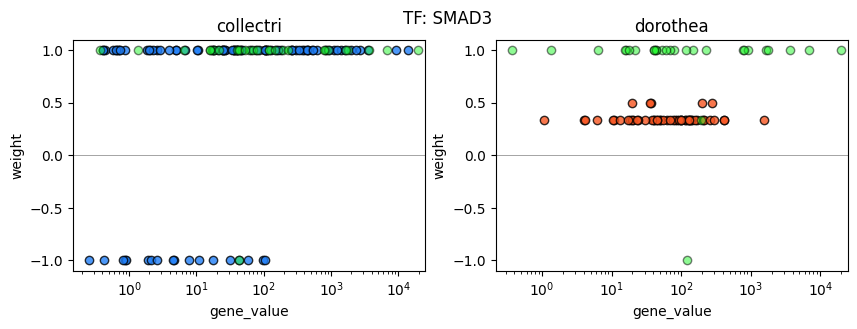

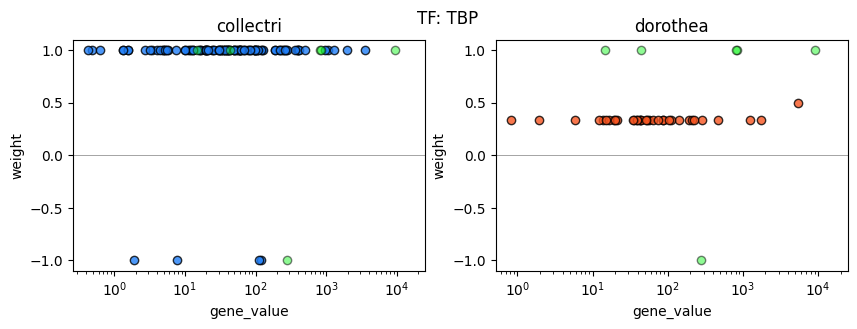

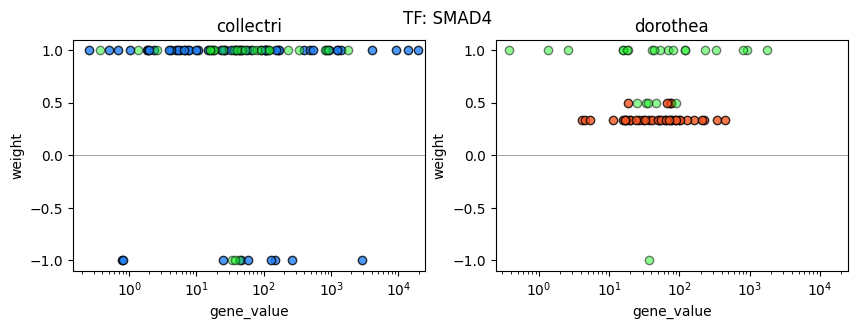

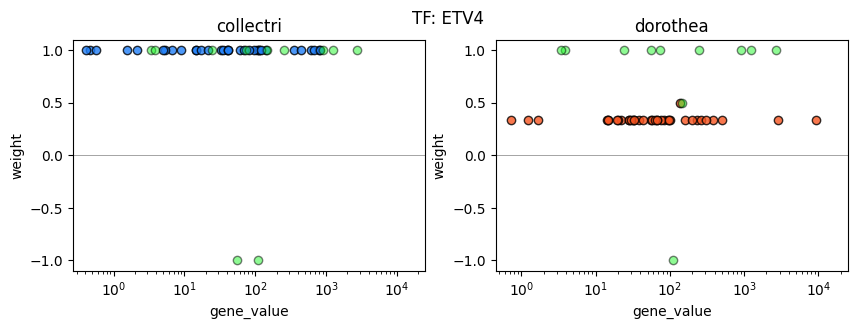

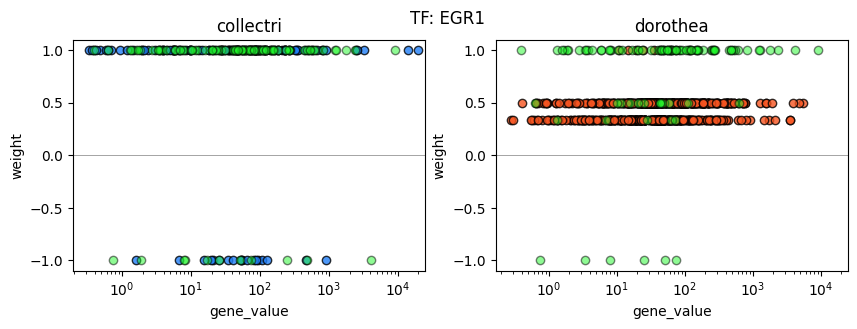

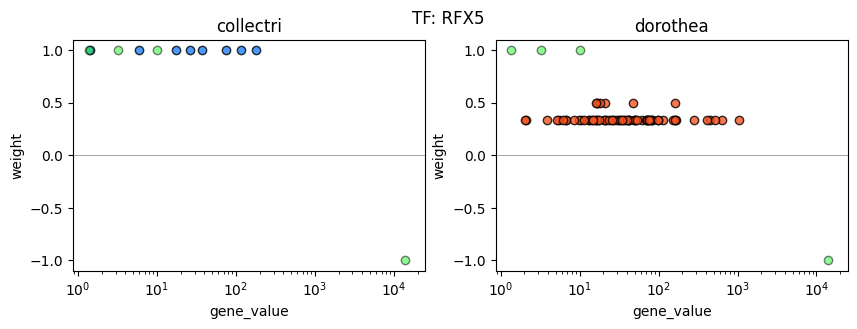

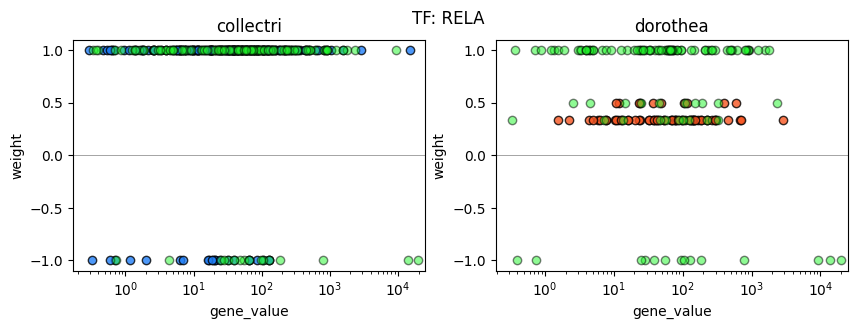

In [ ]:
# Select 'SMAD3'

def plot_tval_individual(select_tf):
    # select_tf = 'SMAD3'
    select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
    select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

    # Get list of regulons
    select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
    select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

    select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
    select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

    select_overlap = select_mat_collectri.loc[select_mat_collectri.target.isin(select_mat_dorothea.target)]['target'].to_list()
    select_mat_collectri_overlap = select_mat_collectri.loc[ select_mat_collectri.target.isin(select_overlap) ]
    select_mat_dorothea_overlap = select_mat_dorothea.loc[ select_mat_dorothea.target.isin(select_overlap) ]

    select_mat_collectri = select_mat_collectri.loc[~select_mat_collectri.target.isin(select_overlap)]
    select_mat_dorothea = select_mat_dorothea.loc[~select_mat_dorothea.target.isin(select_overlap)]

    # Create a scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'TF: {select_tf}')

    # Combine the 'tab20' and 'Set3' palettes
    colors = sns.color_palette(None, 4)

    axes[0].set_title('collectri')
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri,
                    color="#217FF7",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.5)

    axes[0].set_xscale('log')
    axes[0].set_xlim([-1e3,2.5e4])

    axes[1].set_title('dorothea')
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea,
                    color="#f75521",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.5)

    axes[1].set_xscale('log')
    axes[1].set_xlim([-1e3,2.5e4])

    # plot horizontal line at y=0
    axes[0].axhline(0, color='gray', linewidth=0.5)
    axes[0].axvline(0, color='gray', linewidth=0.5)

    # plot vertical line at x=0
    axes[1].axvline(0, color='gray', linewidth=0.5)
    axes[1].axhline(0, color='gray', linewidth=0.5)

# plot_tval_individual('SMAD3')
for col in matched_columns_filtered_selected:
    plot_tval_individual(col)

In [ ]:
# Calculate TF activity score for each TF
def mat_cov(A, b):
    return np.dot(b.T - b.mean(), A - A.mean(axis=0)) / (b.shape[0]-1)

def mat_cor(A, b):
    cov = mat_cov(A, b)
    ssd = np.std(A, axis=0, ddof=1) * np.std(b, axis=0, ddof=1).reshape(-1, 1)
    return cov / ssd

def t_val(r, df):
    return r * np.sqrt(df / ((1.0 - r + 1.0e-16)*(1.0 + r + 1.0e-16)))

select_tf = 'SMAD3'
select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

# Get list of regulons
select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

r = mat_cor(select_mat_collectri.weight, select_mat_collectri.gene_value)
es = t_val(r, select_mat_collectri.shape[0] - 2)
print("T-value of Slope:", es)


T-value of Slope: [[1.3085555]]


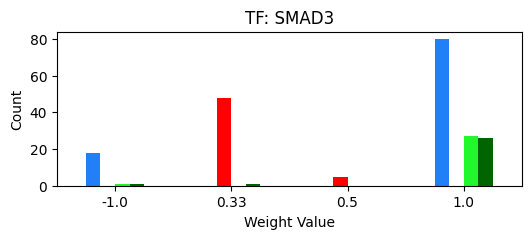

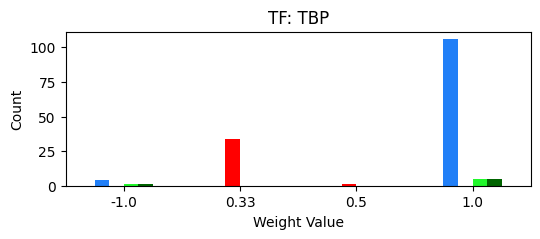

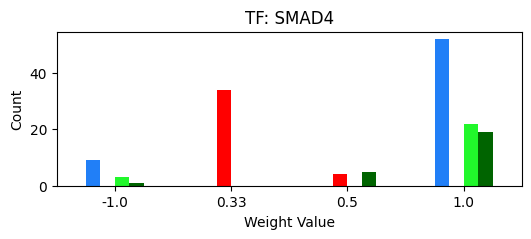

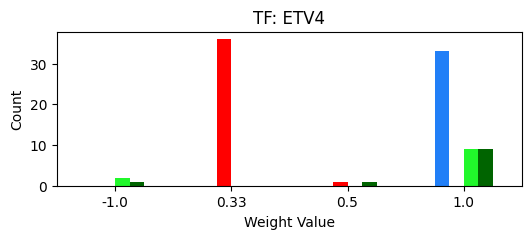

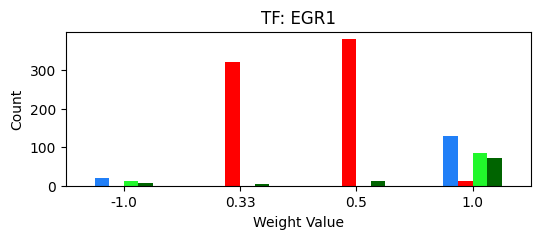

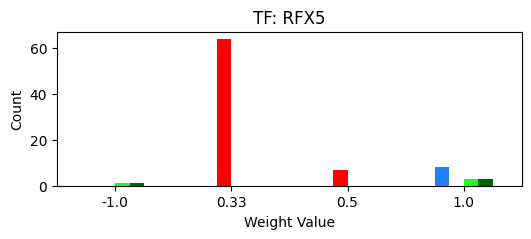

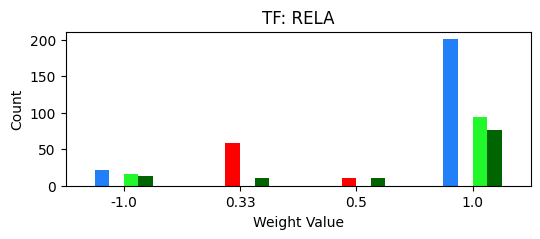

In [ ]:
# Select 'SMAD3'

def plot_count_regulons(select_tf):
    # select_tf = 'SMAD3'
    select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
    select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

    # Get list of regulons
    select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
    select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

    select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
    select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

    select_overlap = select_mat_collectri.loc[select_mat_collectri.target.isin(select_mat_dorothea.target)]['target'].to_list()
    select_mat_collectri_overlap = select_mat_collectri.loc[ select_mat_collectri.target.isin(select_overlap) ]
    select_mat_dorothea_overlap = select_mat_dorothea.loc[ select_mat_dorothea.target.isin(select_overlap) ]

    select_mat_collectri = select_mat_collectri.loc[~select_mat_collectri.target.isin(select_overlap)]
    select_mat_dorothea = select_mat_dorothea.loc[~select_mat_dorothea.target.isin(select_overlap)]


    # pd.merge(select_mat_collectri_overlap,select_mat_dorothea_overlap,on='target')

    # Create a DataFrame with the counts
    counts_df = pd.DataFrame({
        'collectri': select_mat_collectri['weight'].value_counts(),
        'dorothea': select_mat_dorothea['weight'].value_counts(),
        'collectri_overlap': select_mat_collectri_overlap['weight'].value_counts(),
        'dorothea_overlap': select_mat_dorothea_overlap['weight'].value_counts(),
    })

    # Fill NaN values with 0
    counts_df = counts_df.fillna(0)
    counts_df.index = counts_df.index.to_series().round(2).astype(str)

    # Plot the DataFrame
    colors = ['#217FF7', 'red', '#21f72b', 'darkgreen']
    ax = counts_df.plot(kind='bar', figsize=(6, 2), color=colors)
    plt.xticks(rotation=0)
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    plt.title(f'TF: {select_tf}')
    plt.legend().set_visible(False)
    plt.show()

# plot_count_regulons('SMAD3')
for col in matched_columns_filtered_selected:
    plot_count_regulons(col)

In [ ]:
# Merge two dataframe tables and rename the row names

df_wodea = pd.concat([
    tf_collectri_acts.iloc[0:3,],
    tf_dorothea_acts.iloc[0:3,],
    tf_collectri_acts.iloc[3:6,],
    tf_dorothea_acts.iloc[3:6,]
], axis=0, join='inner', sort=False)

df_wodea.index = ['control_25_collectri',
'control_26_collectri',
'control_27_collectri',
'control_25_dorothea',
'control_26_dorothea',
'control_27_dorothea',
'treatment_31_collectri',
'treatment_32_collectri',
'treatment_33_collectri',
'treatment_31_dorothea',
'treatment_32_dorothea',
'treatment_33_dorothea']

df_wodea

,AHR,AR,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,ATF6,...,YY1,ZBED1,ZBTB33,ZBTB7A,ZEB1,ZEB2,ZHX2,ZNF143,ZNF263,ZNF384
control_25_collectri,3.513768,7.374182,0.792456,1.198286,2.654510,2.785471,6.056330,5.635913,3.636624,2.615047,...,8.715239,2.381996,-1.141674,-1.290222,-12.120121,-2.908425,0.385789,0.089191,0.301880,17.152018
control_26_collectri,3.439764,7.277483,0.805713,1.125570,2.602200,2.350424,6.752047,6.186154,3.380385,2.349293,...,9.215903,2.082944,-1.217136,-1.271940,-12.485945,-1.751704,0.340867,0.073348,0.484727,19.226736
control_27_collectri,3.423932,7.011393,0.803646,1.120977,2.618362,2.621725,6.114440,5.627210,3.414000,2.376799,...,9.471114,2.486660,-1.369599,-1.328834,-13.637736,-2.820415,0.338897,0.069136,0.361005,19.752375
control_25_dorothea,1.021086,3.672184,0.081744,2.697176,0.406037,1.640476,9.651978,0.612117,1.249952,4.558881,...,0.120190,0.830525,1.316495,3.326636,7.565924,5.333564,1.066102,0.994266,2.313812,1.458922
control_26_dorothea,0.837120,3.125765,0.059671,2.484155,0.425281,1.518833,11.370803,0.600986,1.228788,4.129539,...,0.217628,0.697476,1.146904,3.190058,7.463633,5.112087,0.990801,1.010280,2.313849,1.381332
control_27_dorothea,0.733425,3.235074,0.039755,2.302288,0.379323,1.453785,9.988415,0.632513,1.174859,4.124165,...,0.147464,0.715901,1.008755,3.540641,7.073108,5.214593,1.036648,1.007952,2.391270,1.257836
treatment_31_collectri,2.637449,8.492096,0.297469,1.458125,1.839883,-0.137174,12.579825,13.259231,1.412705,1.391680,...,6.307020,0.939028,-0.417848,-0.290940,0.344045,16.448116,0.164784,-0.059671,0.085553,16.974936
treatment_32_collectri,2.539009,8.553974,0.306204,1.344882,1.748260,-0.229812,12.704719,13.202457,1.277132,1.351969,...,6.155406,0.714664,-0.352143,-0.208509,0.914211,16.542549,0.159936,-0.077539,0.080793,16.314453
treatment_33_collectri,2.437673,8.715354,0.262756,1.456021,1.636797,-0.143629,13.176441,14.049950,1.349135,1.276085,...,5.731775,0.822638,-0.403469,-0.211865,2.678041,17.678442,0.156299,-0.080893,0.084433,14.641565
treatment_31_dorothea,0.146720,1.907997,0.030676,1.489435,0.167627,0.882310,24.084148,0.323295,0.646517,2.472003,...,0.387686,0.173485,0.386527,1.383568,5.270473,2.422393,0.286207,0.401297,0.951346,0.557975


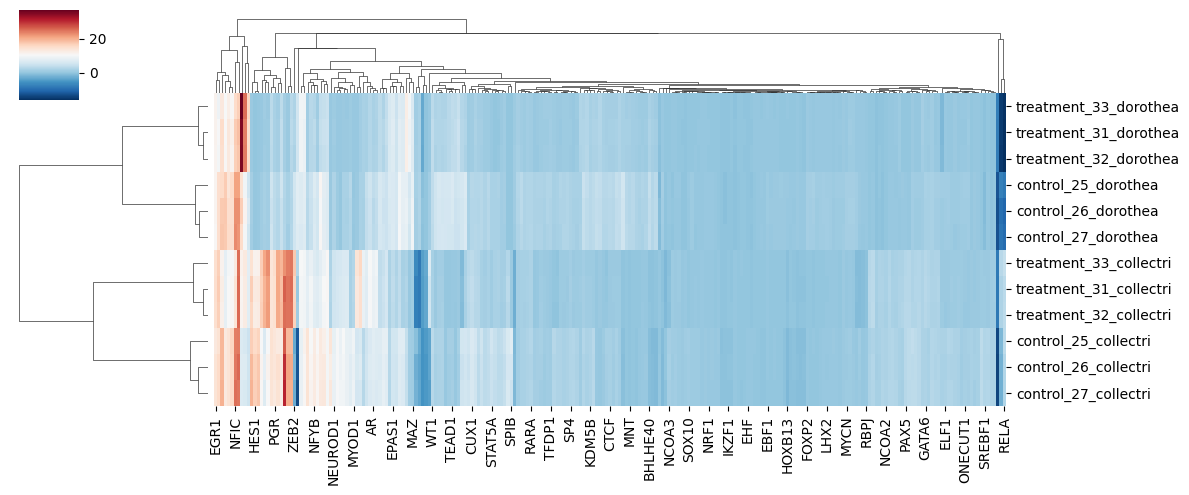

In [ ]:
# Convert dataframe to anndata object
adata_wodea = sc.AnnData(df_wodea)

# Plot clustermap
sc.pl.clustermap(adata_wodea, cmap="RdBu_r", figsize=(12,5))

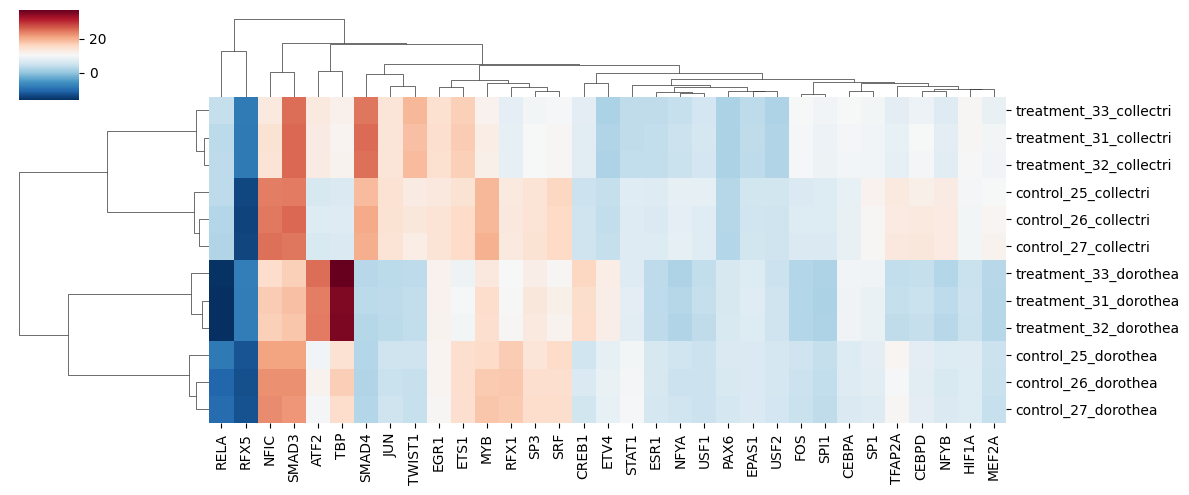

In [ ]:
# Plot clustermap of overlap 33 TFs
df_wodea_overlap = df_wodea[matched_columns_filtered]
adata_wodea_overlap = sc.AnnData(df_wodea_overlap)

# Plot clustermap
sc.pl.clustermap(adata_wodea_overlap, cmap="RdBu_r", figsize=(12,5))

### **TASK 2** With DEA

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata_filtered,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)
dds

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    obsm: 'design_matrix'
    layers: 'counts'

In [ ]:
# Compute LFCs
dds.deseq2()
dds

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 217.05 seconds.

Fitting dispersion trend curve...
... done in 8.38 seconds.

Fitting MAP dispersions...
... done in 215.03 seconds.

Fitting LFCs...
... done in 13.95 seconds.

Refitting 0 outliers.



AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'counts', 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [ ]:
# Extract contrast between treatment vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 4.51 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.067094,0.294257,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.801351
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.634443,0.286075,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.579098,0.270626,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.278378,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.323882,0.302438,-1.070903,0.284213,0.387995


In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 30.00 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


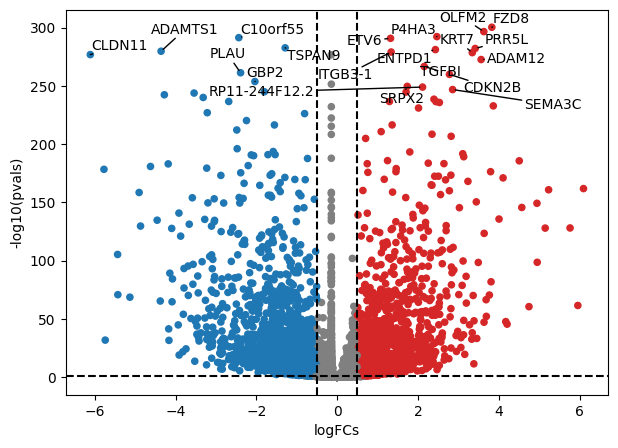

In [ ]:
# Show Vocano Plot
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

In [ ]:
# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,0.22801,-0.345438,0.816925,-2.217747,2.139848,-0.422515,-1.373661,-0.53866,-2.845663,-3.862065,...,-1.472827,0.550156,0.704443,1.049607,-1.283784,-1.601475,-1.191996,-1.070903,-1.49019,-2.362806


CollecTRI network

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
treatment.vs.control,-1.757384,-2.041384,-1.317279,-2.718626,-2.338566,0.178862,-6.440889,1.410645,2.23343,-0.704304,...,-1.164067,-0.933561,2.687689,1.49982,-1.249087,-1.407577,-0.820753,0.485726,2.157699,0.86518


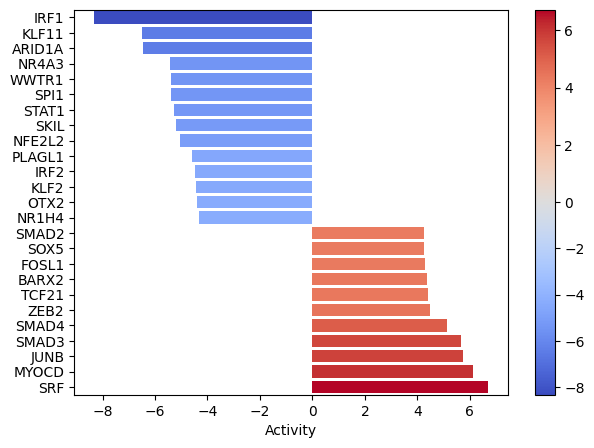

In [ ]:
# Show the obtained scores for the top active/inactive transcription factors
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

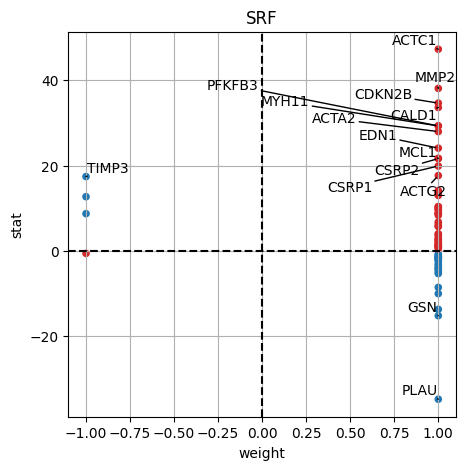

In [ ]:
# Manually inspect the downstream targets of each transcription factor
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=collectri, top=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


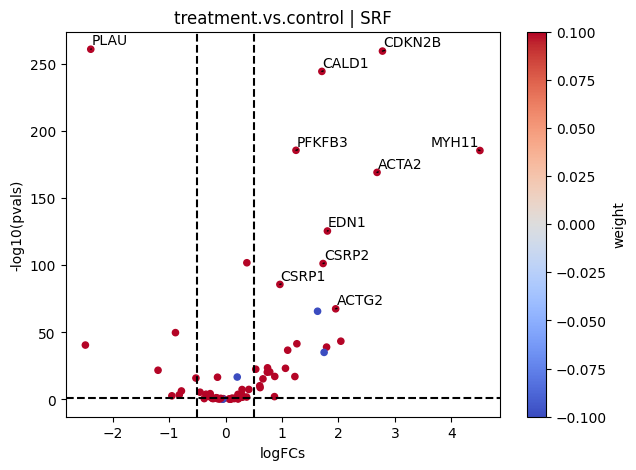

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)